<a href="https://colab.research.google.com/github/eugeneteoh/COMP6248-Deep-Learning/blob/master/lab_4/exercise/lab4ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

try:
    import pytorch_lightning as pl
except:
    !pip install pytorch-lightning
    import pytorch_lightning as pl
from pytorch_lightning import Trainer

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

     |████████████████████████████████| 849kB 20.5MB/s 
     |████████████████████████████████| 112kB 20.7MB/s 
     |████████████████████████████████| 829kB 43.1MB/s 
     |████████████████████████████████| 276kB 47.8MB/s 
     |████████████████████████████████| 184kB 52.5MB/s 
     |████████████████████████████████| 1.3MB 50.0MB/s 
     |████████████████████████████████| 143kB 47.1MB/s 
     |████████████████████████████████| 296kB 56.4MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=80ae1fa0cde4eeb9d2043ab02651c2a8de2249424fef30a678ea0f5720e3d42f
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=d5b41309c4cd0a64a629a011a6358d63e060db14726bbb8b3c7bbabd82cfad96
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built futur

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Loading the MNIST data

In [4]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

In [5]:
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128)

## Defining the MLP model

In [7]:
# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

## Training and Evaluating the Model


In [8]:
def train_model(model):
    # define the loss function and the optimiser
    loss_function = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters())

    train_loss = torch.empty(10).to(device)
    train_acc = torch.empty(10).to(device)

    test_loss = torch.empty(10).to(device)
    test_acc = torch.empty(10).to(device)

    # the epoch loop
    for epoch in range(10):
        running_loss = 0.0
        acc = 0.0
        for data in trainloader:
            model.train()
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimiser.zero_grad()

            # forward + loss + backward + optimise (update weights)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimiser.step()

            # keep track of the loss this epoch
            running_loss += loss.item()
            
            # eval accuracy
            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            acc += (preds == labels).sum()
            

        acc /= len(trainloader.dataset)
        running_loss /= len(trainloader)

        train_loss[epoch] = running_loss
        train_acc[epoch] = acc

        
        # test evaluation
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            acc = 0.0
            for data in testloader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
            
                loss = F.nll_loss(torch.log(outputs), labels)

                acc += (preds == labels).sum()
                running_loss += loss.item()

            acc /= len(testloader.dataset)
            running_loss /= len(testloader)

            test_loss[epoch] = running_loss
            test_acc[epoch] = acc

        print(f"Epoch {epoch}, train loss {train_loss[epoch]}, train accuracy {train_acc[epoch]}, test loss {test_loss[epoch]}, test accuracy {test_acc[epoch]}")


    print('**** Finished Training ****')

    return train_loss.cpu().numpy(), train_acc.cpu().numpy(), test_loss.cpu().numpy(), test_acc.cpu().numpy()


In [16]:
model_list = []
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

hidden_size_list = [500, 1000, 5000, 10000, 25000]

for hidden_size in hidden_size_list:
    print(f"hidden_size = {hidden_size}")
    model = BaselineModel(784, hidden_size, 10).to(device)
    train_loss, train_acc, test_loss, test_acc = train_model(model)

    model_list.append(model)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print("\n")

hidden_size = 500
Epoch 0, train loss 0.31556761264801025, train accuracy 0.9199833273887634, test loss 0.1585310399532318, test accuracy 0.9549999833106995
Epoch 1, train loss 0.127782940864563, train accuracy 0.9664666652679443, test loss 0.10637187957763672, test accuracy 0.9685999751091003
Epoch 2, train loss 0.08344796299934387, train accuracy 0.9784500002861023, test loss 0.08316004276275635, test accuracy 0.9727999567985535
Epoch 3, train loss 0.060900963842868805, train accuracy 0.9853333234786987, test loss 0.0745926946401596, test accuracy 0.9765999913215637
Epoch 4, train loss 0.04487176239490509, train accuracy 0.9894500374794006, test loss 0.0679352879524231, test accuracy 0.9781999588012695
Epoch 5, train loss 0.03469426929950714, train accuracy 0.992566704750061, test loss 0.06722531467676163, test accuracy 0.9785999655723572
Epoch 6, train loss 0.025871509686112404, train accuracy 0.9953500032424927, test loss 0.0619298554956913, test accuracy 0.98089998960495
Epoch 7, 

Text(0.5, 0, 'Epoch')

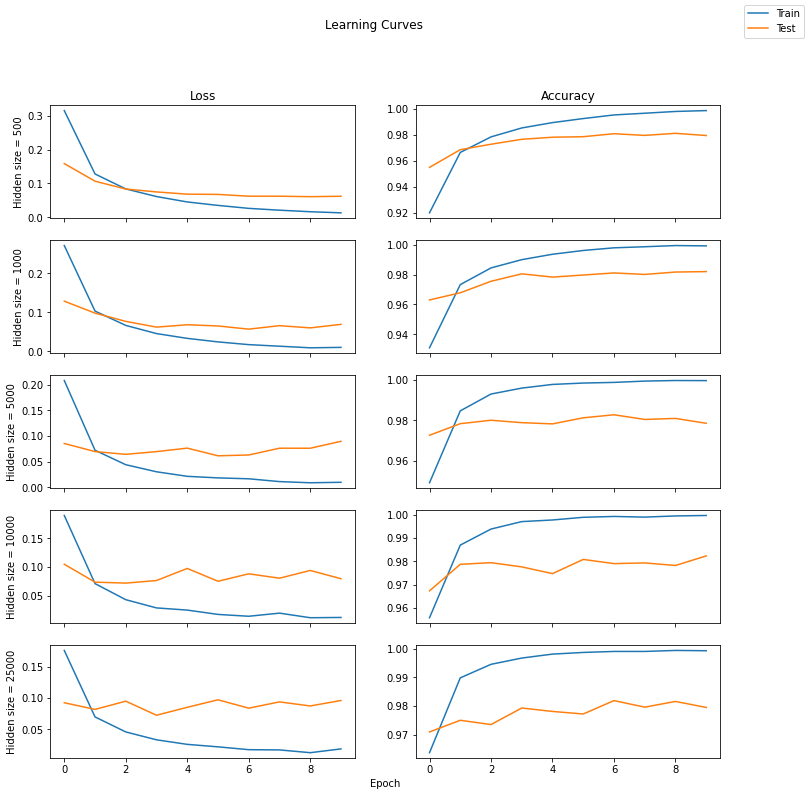

In [63]:
fig, ax = plt.subplots(len(model_list), 2, figsize=(12, 12), sharex=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
for i in range(len(model_list)):
    ax[i, 0].plot(train_loss_list[i])
    ax[i, 0].plot(test_loss_list[i])
    ax[i, 1].plot(train_acc_list[i])
    ax[i, 1].plot(test_acc_list[i])
    ax[i, 0].set_ylabel(f"Hidden size = {hidden_size_list[i]}")
ax[0, 0].set_title("Loss")
ax[0, 1].set_title("Accuracy")
fig.legend(["Train", "Test"])
fig.suptitle("Learning Curves")
plt.xlabel("Epoch")


In [64]:
# fig.savefig("learning_curves.pdf")